In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ristek-data-challenge-3/archive/sample_submission.csv
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016292.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_014007.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_004644.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_014288.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_004565.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016233.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016082.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016109.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016455.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_004244.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_004961.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016309.jpg
/kaggle/input/ristek-data-challenge-3/archive/test/Image_016078.jpg
/kaggle/input/ristek-data-challenge-3/archive/te

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


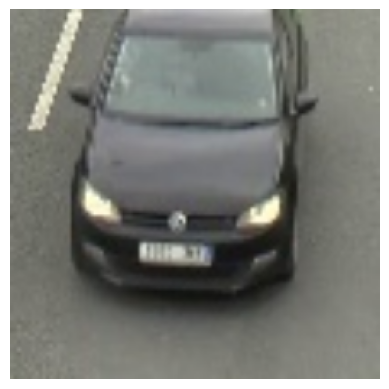

In [4]:
image_path = '/kaggle/input/ristek-data-challenge-3/archive/train/Car/Image_000578.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

plt.imshow(image)
plt.axis('off')  # To hide the axes labels
plt.show()

In [5]:
image.shape

(256, 256, 3)

In [6]:
from tqdm import tqdm
# Rest of the code
directory = "/kaggle/input/ristek-data-challenge-3/archive"
train_dir = os.path.join(directory, "train/")

X = []
y = []
label_mapping = {"Van": 0, "Car": 1, "Truck": 2}  # Define label mapping

for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if not os.path.isdir(category_dir):
        continue

    for image_file in tqdm(os.listdir(category_dir)):
        image_path = os.path.join(category_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        X.append(image)
        y.append(label_mapping[category])

X = np.array(X)
y = np.array(y)

100%|██████████| 3583/3583 [00:38<00:00, 92.73it/s]


In [7]:
set(y)

{0, 1, 2}

In [8]:
# Kita gunakan tensorflow, dengan GPU

import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU tidak ditemukan')

print('Ditemukan GPU di lokasi: {}'.format(device_name))

Ditemukan GPU di lokasi: /device:GPU:0


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5192, 256, 256, 3)
y_train shape: (5192,)
X_test shape: (1298, 256, 256, 3)
y_test shape: (1298,)


In [10]:
# scaling, daripada menggunakan 0 - 255; kita
# # gunakan 0 - 1
# X_train = X_train / 255
# X_test  = X_test  / 255

In [11]:
import tensorflow as tf
# encoding labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 3)

print(y_train)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [12]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Membuat model augmentasi data dengan Image Data Generator
# # train_datagen = ImageDataGenerator(
# #                     rescale=1./255,  # scaling 0-255 menjadi 0-1
# #                     zoom_range=0.2, 
# #                     width_shift_range=0.1,
# #                     height_shift_range=0.1,
# #                     rotation_range=20,
# #                     horizontal_flip=True,
# #                     shear_range = 0.2,
# #                     fill_mode = 'nearest')

# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# with tf.device('/device:GPU:0'):
# # Mengaplikasikan augmentasi terhadap data
#     train_datagen.fit(X_train)
#     train_generator = train_datagen.flow(
#             X_train,y_train,  
#             batch_size=32)

#     val_datagen.fit(X_test)
#     validation_generator = val_datagen.flow(
#             X_test,y_test, 
#             batch_size=16)

In [14]:
# Menggunakan fungsi callback

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=1,
                            write_graph=True, write_images=True)

check_point  = ModelCheckpoint('./model-{epoch:03d}.model',
                               monitor='val_loss',
                               save_best_only=True,
                               mode='auto')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.4,   
    patience=4, 
    verbose=1)

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
import tensorflow as tf


def conv2d_bn(x, filters, kernel_size, strides=1, activation='relu'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation is not None:
        x = tf.keras.layers.Activation(activation)(x)
    return x


def basic_block(x, filters, strides=1, downsample=False):
    identity = x

    x = conv2d_bn(x, filters, kernel_size=3, strides=strides)
    x = conv2d_bn(x, filters, kernel_size=3, activation=None)

    if downsample:
        identity = conv2d_bn(identity, filters, kernel_size=1, strides=strides, activation=None)

    x = tf.keras.layers.Add()([x, identity])
    x = tf.keras.layers.Activation('relu')(x)
    return x


def resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = conv2d_bn(inputs, 64, kernel_size=7, strides=2)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = basic_block(x, 64)
    x = basic_block(x, 64)

    x = basic_block(x, 128, strides=2, downsample=True)
    x = basic_block(x, 128)

    x = basic_block(x, 256, strides=2, downsample=True)
    x = basic_block(x, 256)

    x = basic_block(x, 512, strides=2, downsample=True)
    x = basic_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


# Create a ResNet model with 10 output classes

model = resnet(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), num_classes=3)

In [ ]:
model.summary()

In [18]:
with tf.device('/device:GPU:0'):
    model.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = [f1_m])
    history = model.fit(
                X_train,
                y_train,
    #             X_train,
                batch_size=32,  # berapa batch yang akan dieksekusi pada setiap epoch
                epochs=30,
                validation_data=(X_test,y_test), # menampilkan akurasi pengujian data validasi
                validation_steps=16,  # berapa batch yang akan dieksekusi pada setiap epoch
                verbose=2,
                callbacks = [reduce_lr,tensor_board,check_point])

Epoch 1/30
163/163 - 53s - loss: 0.6322 - f1_m: 0.7773 - val_loss: 10.2475 - val_f1_m: 0.3340 - lr: 0.0010 - 53s/epoch - 324ms/step
Epoch 2/30
163/163 - 28s - loss: 0.3184 - f1_m: 0.8791 - val_loss: 4.1535 - val_f1_m: 0.4121 - lr: 0.0010 - 28s/epoch - 171ms/step
Epoch 3/30
163/163 - 26s - loss: 0.2136 - f1_m: 0.9163 - val_loss: 5.5049 - val_f1_m: 0.3910 - lr: 0.0010 - 26s/epoch - 161ms/step
Epoch 4/30
163/163 - 26s - loss: 0.1683 - f1_m: 0.9378 - val_loss: 2.7563 - val_f1_m: 0.5170 - lr: 0.0010 - 26s/epoch - 161ms/step
Epoch 5/30
163/163 - 27s - loss: 0.1650 - f1_m: 0.9419 - val_loss: 8.3610 - val_f1_m: 0.4668 - lr: 0.0010 - 27s/epoch - 165ms/step
Epoch 6/30
163/163 - 27s - loss: 0.1144 - f1_m: 0.9593 - val_loss: 4.0833 - val_f1_m: 0.4204 - lr: 0.0010 - 27s/epoch - 166ms/step
Epoch 7/30
163/163 - 27s - loss: 0.0869 - f1_m: 0.9688 - val_loss: 5.9657 - val_f1_m: 0.3821 - lr: 0.0010 - 27s/epoch - 166ms/step
Epoch 8/30
163/163 - 27s - loss: 0.0770 - f1_m: 0.9716 - val_loss: 1.4049 - val_f1

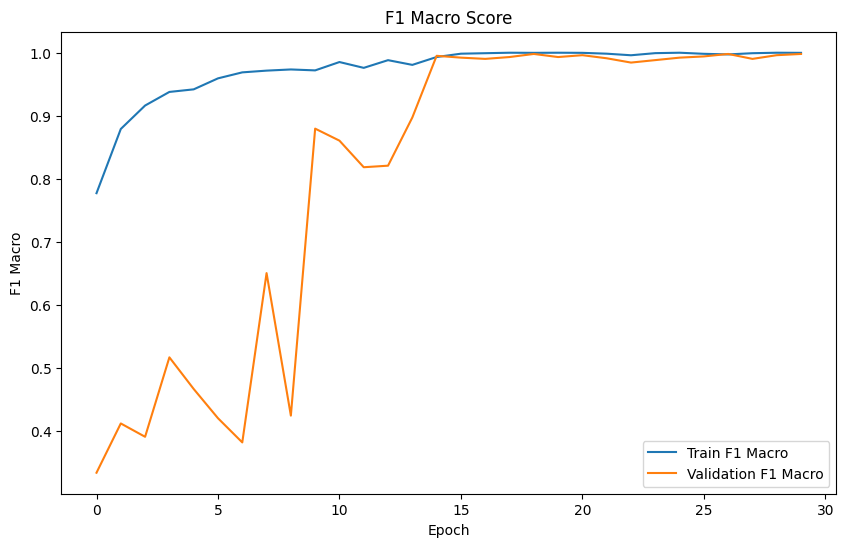

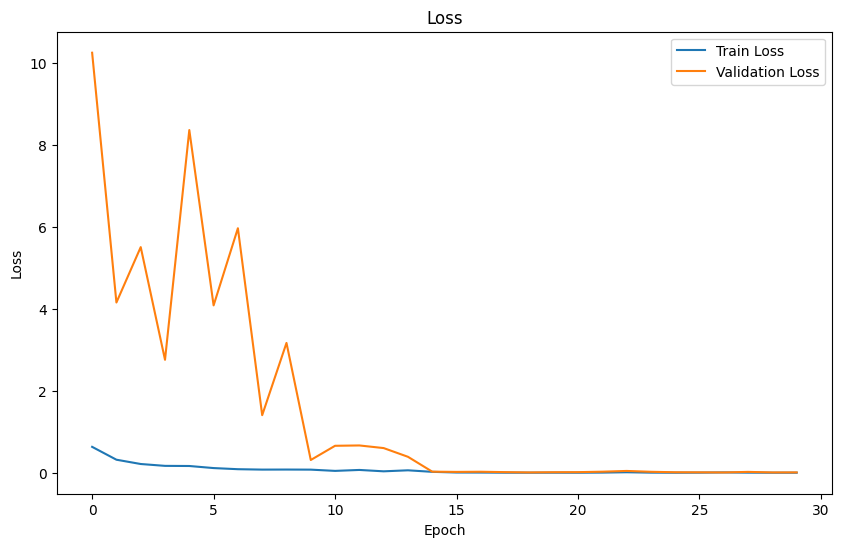

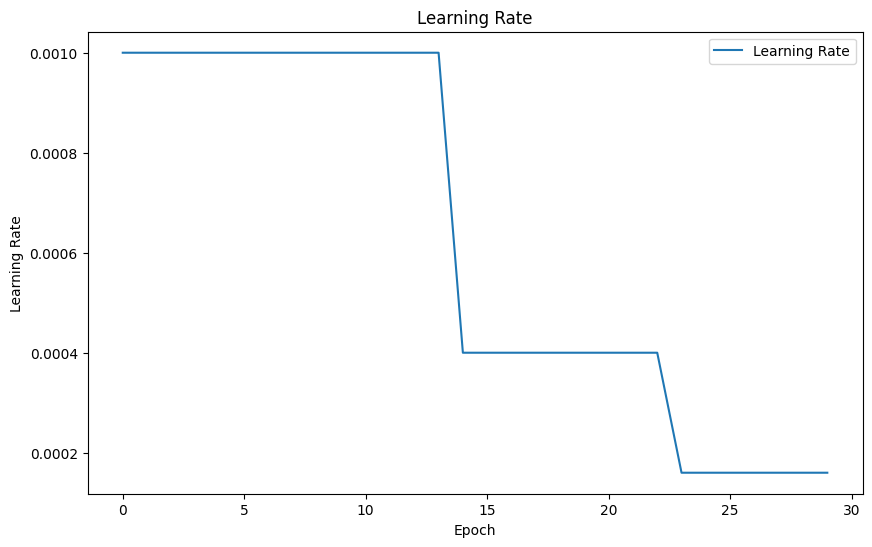

In [19]:
import matplotlib.pyplot as plt

# Get the F1 macro scores, loss, and learning rate from the history object
f1_macro = history.history['f1_m']
val_f1_macro = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history['lr']

# Plot the F1 macro scores
plt.figure(figsize=(10, 6))
plt.plot(f1_macro, label='Train F1 Macro')
plt.plot(val_f1_macro, label='Validation F1 Macro')
plt.xlabel('Epoch')
plt.ylabel('F1 Macro')
plt.title('F1 Macro Score')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.show()

In [20]:
preds = model.predict(X_test)
print(preds)

41/41 [==============================] - 3s 50ms/step
[[3.1222487e-07 9.9999964e-01 2.4195785e-09]
 [1.4559876e-12 1.0000000e+00 4.8931015e-10]
 [9.9999988e-01 7.6659653e-08 2.6504946e-08]
 ...
 [1.6260332e-05 9.9998379e-01 2.1594544e-09]
 [4.2049076e-02 9.5544189e-01 2.5089937e-03]
 [1.4551374e-07 2.3833285e-05 9.9997604e-01]]


In [21]:
X_test.shape

(1298, 256, 256, 3)

In [22]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [23]:
np.argmax(preds, axis=1).shape

(1298,)

In [24]:
pd.Series(np.argmax(preds, axis=1)).value_counts()

1    701
0    338
2    259
dtype: int64

In [25]:
pd.Series(np.argmax(y_test,axis=1)).value_counts()

1    702
0    337
2    259
dtype: int64

In [26]:
from sklearn.metrics import f1_score

# Assuming you have predicted labels as y_pred and true labels as y_true

# Calculate F1 macro score
f1_macro = f1_score(np.argmax(y_test,axis=1), np.argmax(preds, axis=1), average='macro')

print("F1 macro score:", f1_macro)

F1 macro score: 0.9955311045356187


In [27]:
from tqdm import tqdm
# Rest of the code
directory = "/kaggle/input/ristek-data-challenge-3/archive"
test_dir = os.path.join(directory, "test/")

files = []
test = []


for image_file in tqdm(os.listdir(test_dir)):
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    files.append(image_file)
    test.append(image)

test = np.array(test)

100%|██████████| 2061/2061 [00:23<00:00, 88.54it/s]


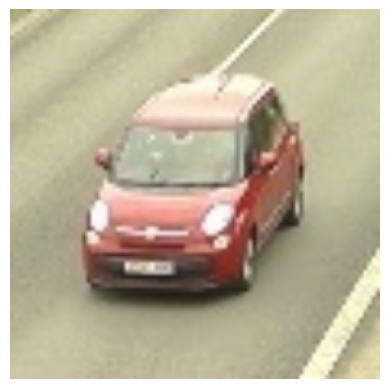

In [28]:
image_path = '/kaggle/input/ristek-data-challenge-3/archive/test/Image_004837.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

plt.imshow(image)
plt.axis('off')  # To hide the axes labels
plt.show()

In [29]:
final_pred = model.predict(test)

65/65 [==============================] - 3s 46ms/step


In [30]:
subs = pd.DataFrame({'id':files,'label':np.argmax(final_pred, axis=1)})

In [31]:
subs.sort_values(by='id').to_csv("submission.csv", index=False)